In [47]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Import modules and necessary core and helper functions

In [48]:
import os
import sys
sys.path.insert(0,'/home/meyerann/WPG')

import time
import copy
import numpy
import pylab

#Base wavefront class
from wpg import Wavefront

from wpg.srwlib import srwl,SRWLOptD,SRWLOptL,SRWLOptC,SRWLOptA
#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy
#helper functions
#from wfrutilsAKM import plot_wfront
from wpg.useful_code.wfrutils import plot_wfront, get_mesh,print_beamline,calculate_fwhm_x

pylab.ion()

In [49]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011
    
    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

In [50]:
def defineEFM(orient,p,q,thetaEFM,theta0,lengthEFM):
    """
    A wrapper to a SRWL function SRWLOptMirEl() for defining a plane elliptical focusing mirror propagator
    
    :param Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :param p:  the distance to two ellipsis centers
    :param q:  the distance to two ellipsis centers
    :param thetaEFM:  the design incidence angle in the center of the mirror
    :param theta0:    the "real" incidence angle in the center of the mirror
    :param lengthEFM: mirror length, [m]
    :return: the struct opEFM
    """
    if orient == 'x':     #horizontal plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=cos(theta0), _nvy=0, _nvz=-sin(theta0), _tvx=-sin(theta0), _tvy=0, _x=0, _y=0, _treat_in_out=1) 
    elif orient == 'y': #vertical plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=0, _nvy=cos(theta0), _nvz=-sin(theta0), _tvx=0, _tvy=-sin(theta0), _x=0, _y=0, _treat_in_out=1)
    else:
        raise TypeError('orient should be "x" or "y"')
    return opEFM

### Useful formulas for calculation Gaussian wavefront parameters and focal length of thin lenses

${\omega}_0$: beam waist

$\lambda=\frac{12.4}{E[kev]}$: wave length of beam

$\theta = \frac{\lambda}{\pi\omega_0}$ --> $\omega_0 = \frac{\lambda}{\pi\theta}$

${z}_R=\frac{\pi{\omega_0}^2}{\lambda}$ Rayleigh length/range. At this point the beam is widened to $\sqrt{2}\omega_0$

Comparison of the intensity of the wavefront and normal distribution

$\frac{1}{2} = exp(-\frac{r^2}{2\sigma^2}) = exp(-\frac{2r^2}{\omega(z)^2})$

$\frac{r^2}{2\sigma^2} = \frac{2r^2}{\omega(z)^2}$

$\frac{1}{2\sigma^2} = \frac{2}{\omega(z)^2}$

$\frac{\omega(z)^2}{2} = 2\sigma^2$

$\frac{\omega(z)^2}{4} = \sigma^2$ ; $\omega(z=0)^2 = \omega_0^2$

beam radius at several point

$\omega(z) = \omega_0*\sqrt{1+(\frac{z}{z_0})^2}$

FWHM of intensity

$\frac{1}{2} = exp(-\frac{2x^2}{w^2})$
-->
$2x = w\sqrt{ln2*2}$ --> $2x = 2*\sigma\sqrt{ln2*2}$ --> $x = \sigma\sqrt{ln2*2}$



FWHM of amplitude

$\frac{1}{2} = exp(-\frac{x^2}{w^2})$
-->
$x = w\sqrt{-ln\frac{1}{2}}$ --> $x = 2*\sigma\sqrt{ln2}$


Focal length for thin lenses

$\frac{1}{f}=\frac{1}{p}+\frac{1}{q}$

### Define Gaussian wavefront parameters and build it.

theta_fwhm [urad]: 18.3457259238
w0 [nm]: 26.8934751142
lamda [nm]: 1.55
2*z0 [nm]: 2.93185183578
sigma_Intensity []: 1.61511778049e-05
expected FWHM at distance 284.0: 5.21 mm
FWHMx [mm]: 5.02743958516
FWHMy [mm]: 5.02743958516
Coordinates of center, [mm]: 0.032645711592 0.032645711592
stepX, stepY [um]: 65.2914231839 65.2914231839 

 
 total length: 284.0


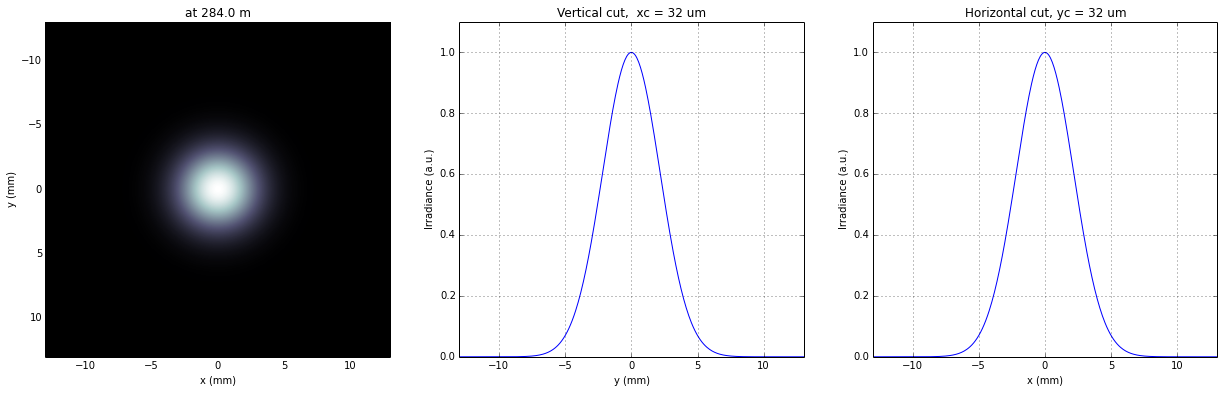

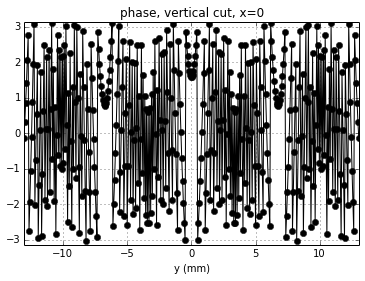

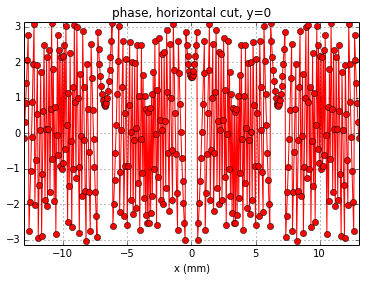

In [51]:
#wavefront parameters
qnC = 0.1                    # e-bunch charge, [nC]
pulse_duration = 9.e-15      # [s]      
ekev = 0.8            # Energy in [keV]
#number of points
np = 400
d2HLens = 284.0
lamda = 12.4*1e-10/ekev # wavelength [AKM]
#calculate angular divergence
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
#calculate rayleigh range z
w0 = lamda/(pi*theta_fwhm) # beam waist
#calculate angular divergence by calculating sigma of amplitude
sigmaAmp = w0/(2*sqrt(log(2)))
#calculate Rayleigh length
z0 = (pi*w0**2)/lamda

#quintuple beam radius at horizontal lens distance to get the range of the wavefront 
range_xy = w0*sqrt(1+(d2HLens/z0)**2) *5
print 'theta_fwhm [urad]:', theta_fwhm*1e6
print 'w0 [nm]:', w0*1e6
print 'lamda [nm]:', lamda*1e9
print '2*z0 [nm]:', 2*z0
print 'sigma_Intensity []:', sigmaAmp
print 'expected FWHM at distance %.1f: %.2f mm' %(d2HLens,theta_fwhm*d2HLens*1e3)


#build wavefront
wfr = build_gauss_wavefront_xy(nx=np, ny=np, ekev=ekev, xMin=-range_xy/2, xMax=range_xy/2, 
                               yMin=-range_xy/2, yMax=range_xy/2, sigX=sigmaAmp, 
                               sigY=sigmaAmp,d2waist=d2HLens)


#init WPG Wavefront helper class
mwf = Wavefront(wfr)

#defining name HDF5 file for storing wavefront
strOutputDataFolder = 'data_common'
wfr0Name = os.path.join(strOutputDataFolder,'gwf_AKM'+'.h5')
#store wavefront to HDF5 file 
mwf.store_hdf5(wfr0Name)


#plot the wavefront
plot_wfront(mwf, title_fig='at '+str(d2HLens)+' m', isHlog=False, isVlog=False,
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True, bPlotPha=True)
print ' '
print ' total length:', mwf.params.Mesh.zCoord

### Focusing with horizontal cylindrical lens
Calculating expected beam size after propagation and
propagate wavefront from frist horizontal lens at 284 m to calculated focus at 374 m.

In [52]:
horizontalFocus = 374.0
q = horizontalFocus-d2HLens
d2horizontalFocus=1./(1./d2HLens + 1./q) #calculating horizontal focal length
print 'horizontalFocus at distance %.1f m' %(d2horizontalFocus+d2HLens)
print 'd2horizontalFocus = %.1f m' %(d2horizontalFocus)
FWHM_1HFocus = d2horizontalFocus/d2HLens*calculate_fwhm_x(mwf)
print 'expected horizontal FWHM at distance %.1f: %.2f mm' %(d2horizontalFocus+d2HLens,FWHM_1HFocus*1e3)

horizontalFocus at distance 352.3 m
d2horizontalFocus = 68.3 m
expected horizontal FWHM at distance 352.3: 1.21 mm


Optical Element: Thin Lens
Prop. parameters = [0, 1, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 90.0
	Fy = 1e+23
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 1, 1.0, 1, 0, 2.0, 1.0, 2.0, 1.0, 0, 0, 0]
	L = 90.0
	treat = 0
	

FWHMx [mm]: 1.60404823477
FWHMy [mm]: 6.68345572054
Coordinates of center, [mm]: 0.0106936548984 0.0423003526616
stepX, stepY [um]: 21.3873097969 84.6007053233 

 
horizontal FWHM at distance 374.0: 1.60 mm
 total length: 284.0


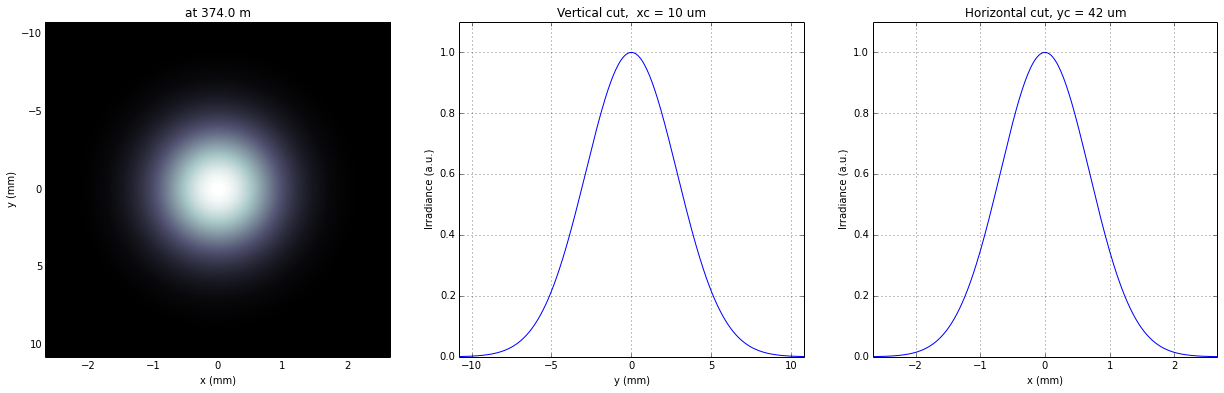

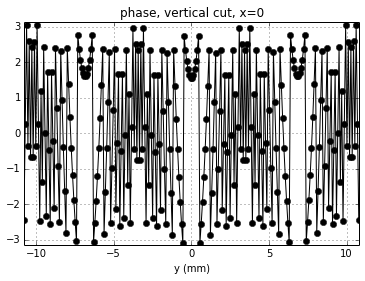

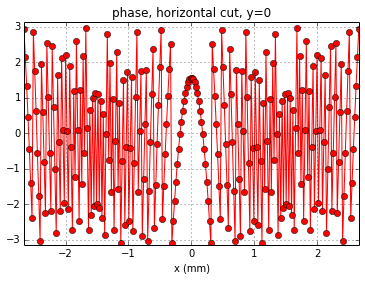

In [53]:
opHorizontalLens=SRWLOptL(_Fx=q)
DriftHLens_Focus = SRWLOptD(q)

#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                  [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppHorizontalLens = [ 0,  1, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftHL_foc =    [ 0,  1, 1.0,  1,  0, 2.0, 1.0, 2.0, 1.0,  0,  0,   0]


optBL0 = SRWLOptC([opHorizontalLens, DriftHLens_Focus],
                  [ppHorizontalLens,ppDriftHL_foc]) 
print_beamline(optBL0)

w2 = Wavefront()
w2.load_hdf5(wfr0Name)
wfr = w2._srwl_wf

srwl.PropagElecField(wfr, optBL0)

mwf = Wavefront(wfr)
mwf.store_hdf5(wfr0Name)
plot_wfront(mwf, title_fig='at '+str(horizontalFocus)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'horizontal FWHM at distance %.1f: %.2f mm' %(horizontalFocus,calculate_fwhm_x(mwf)*1e3)
print ' total length:', mwf.params.Mesh.zCoord

### Focusing with second horizontal cylindrical lens
Calculating expected beam size after propagation and
propagate wavefront from frist horizontal focus at 352.3 m to focus of second horizontal focus at 445 m.

In [54]:
d2HKB = 442.3
dHKB_foc = 2.715  # nominal focal length for HFM KB
d1HL2HKB = d2HKB-horizontalFocus
p = d1HL2HKB
HKB_foc =  1. /(1./p + 1. / dHKB_foc) # for thin lens approx

w2.load_hdf5(wfr0Name)
wfr = w2._srwl_wf
mwf = Wavefront(wfr)

fhwm = calculate_fwhm_x(mwf)
FWHM_2HFocus = dHKB_foc/d1HL2HKB*calculate_fwhm_x(mwf)
print 'horizontalFocus at distance %.1f m' %(HKB_foc+d2HKB)
print 'p %.1f m' %(d1HL2HKB)
print 'dHKB_foc/d1HL2HKB', (dHKB_foc/d1HL2HKB)
print 'calculate_fwhm_x(mwf)', fhwm
print 'expected horizontal FWHM at distance %.1f: %.2f mm' %(HKB_foc+d2HKB,FWHM_2HFocus*1e3)

horizontalFocus at distance 444.9 m
p 68.3 m
dHKB_foc/d1HL2HKB 0.0397510980966
calculate_fwhm_x(mwf) 0.00160404823477
expected horizontal FWHM at distance 444.9: 0.06 mm


Optical Element: Drift Space
Prop. parameters = [0, 1, 1.0, 1, 0, 2.0, 1.0, 2.0, 1.0, 0, 0, 0]
	L = 68.3
	treat = 0
	
Optical Element: Thin Lens
Prop. parameters = [0, 1, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 2.715
	Fy = 1e+23
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 1, 1.0, 1, 0, 2.0, 1.0, 2.0, 1.0, 0, 0, 0]
	L = 2.715
	treat = 0
	

FWHMx [mm]: 0.100768013759
FWHMy [mm]: 7.90238596844
Coordinates of center, [mm]: -0.00136172991567 0.0500151010661
stepX, stepY [um]: 2.72345983133 100.030202132 

 
horizontal FWHM at distance 444.9: 0.101 mm
 total length: 284.0


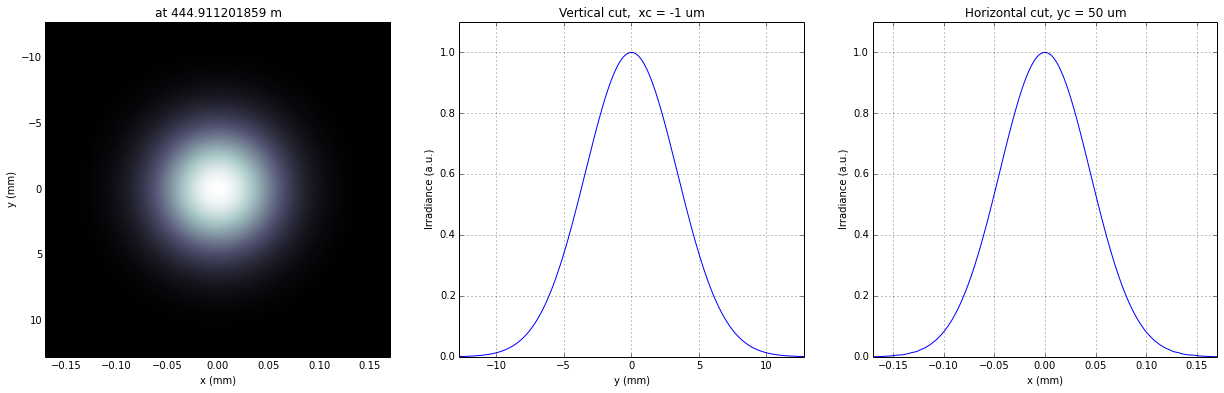

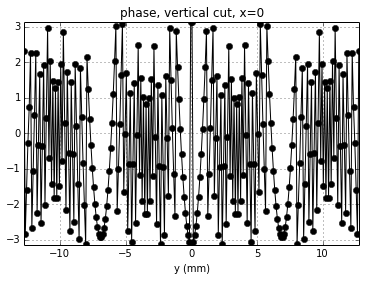

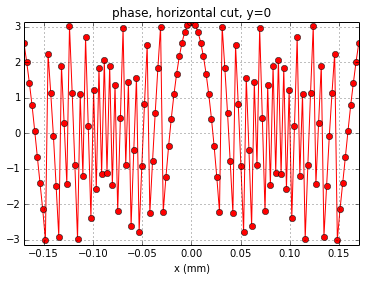

In [55]:
HKB = SRWLOptL(_Fx=dHKB_foc) #HKB as Thin Lens
FWHM_2HFocus = dHKB_foc/d1HL2HKB*calculate_fwhm_x(mwf)
#               [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11] 
ppHKB =         [ 0,  1, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift2HKB =   [ 0,  1, 1.0,  1,  0, 2.0, 1.0, 2.0, 1.0,  0,  0,   0]
ppDrift2Focus = [ 0,  1, 1.0,  1,  0, 2.0, 1.0, 2.0, 1.0,  0,  0,   0]

DriftHFocus1_HKB = SRWLOptD(d1HL2HKB)
Drift2Focus = SRWLOptD(dHKB_foc)

optBL3 = SRWLOptC([DriftHFocus1_HKB, HKB, Drift2Focus],
                  [ppDrift2HKB, ppHKB, ppDrift2Focus]) 
print_beamline(optBL3)

srwl.PropagElecField(wfr, optBL3)
mwf = Wavefront(wfr)

mwf.store_hdf5(wfr0Name)

plot_wfront(mwf, title_fig='at '+str(HKB_foc+d2HKB)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'horizontal FWHM at distance %.1f: %.3f mm' %(HKB_foc+d2HKB,calculate_fwhm_x(mwf)*1e3)
print ' total length:', mwf.params.Mesh.zCoord

### Plot wavefront out of focus at rayleigh length
Propagate the beamline further to distance of rayleigh length at 446m

z0 [nm] : 1.46592591789
Optical Element: Drift Space
Prop. parameters = [0, 1, 1.0, 1, 0, 2.0, 1.0, 2.0, 1.0, 0, 0, 0]
	L = 1.46592591789e-09
	treat = 0
	

FWHMx [mm]: 0.100768013439
FWHMy [mm]: 7.90238596847
Coordinates of center, [mm]: -0.00136172991133 0.0500151010662
stepX, stepY [um]: 2.72345982267 100.030202132 

 
horizontal FWHM at distance 444.9: 0.101 mm
 total length: 284.0


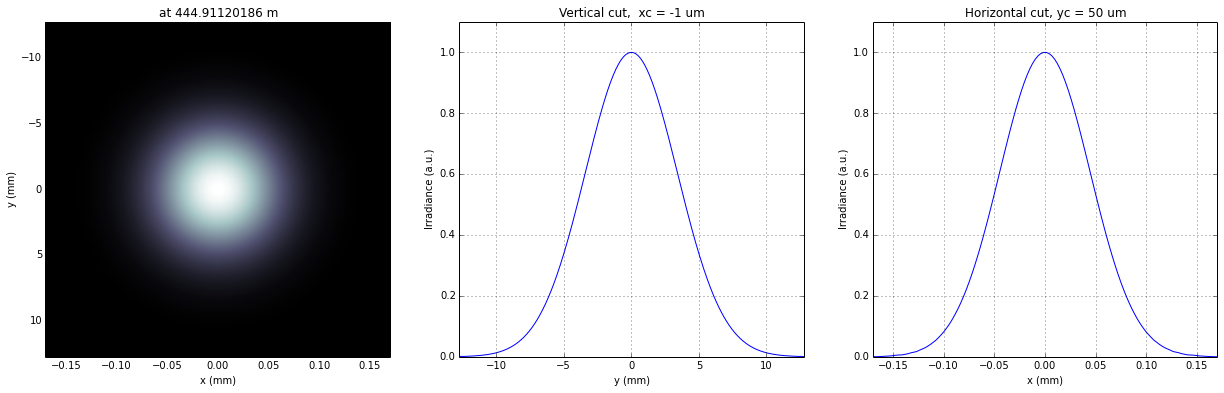

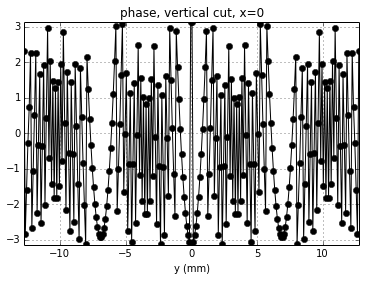

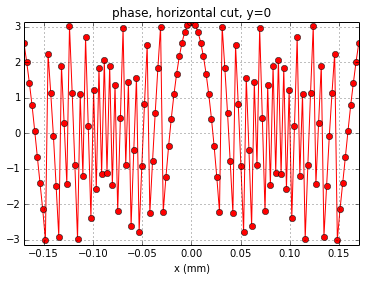

In [56]:
ppDriftHKB2Screen = [ 0,  1, 1.0,  1,  0, 2.0, 1.0, 2.0, 1.0,  0,  0,   0]
DriftHKB = SRWLOptD(z0*1e-9)
print 'z0 [nm] :', z0
optBL4 = SRWLOptC([DriftHKB],
                  [ppDriftHKB2Screen]) 
print_beamline(optBL4)

w2.load_hdf5(wfr0Name)
wfr = w2._srwl_wf
mwf = Wavefront(wfr)

srwl.PropagElecField(wfr, optBL4)
mwf = Wavefront(wfr)

plot_wfront(mwf, title_fig='at '+str(HKB_foc+d2HKB+z0*1e-9)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
print 'horizontal FWHM at distance %.1f: %.3f mm' %(HKB_foc+d2HKB+z0*1e-9,calculate_fwhm_x(mwf)*1e3)
print ' total length:', mwf.params.Mesh.zCoord